<a href="https://colab.research.google.com/github/chongzicbo/Dive-into-Deep-Learning-tf.keras/blob/master/9.2.%20%E5%BE%AE%E8%B0%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##9.2. 微调
在前面的一些章节中，我们介绍了如何在只有6万张图像的Fashion-MNIST训练数据集上训练模型。我们还描述了学术界当下使用最广泛的大规模图像数据集ImageNet，它有超过1,000万的图像和1,000类的物体。然而，我们平常接触到数据集的规模通常在这两者之间。

假设我们想从图像中识别出不同种类的椅子，然后将购买链接推荐给用户。一种可能的方法是先找出100种常见的椅子，为每种椅子拍摄1,000张不同角度的图像，然后在收集到的图像数据集上训练一个分类模型。这个椅子数据集虽然可能比Fashion-MNIST数据集要庞大，但样本数仍然不及ImageNet数据集中样本数的十分之一。这可能会导致适用于ImageNet数据集的复杂模型在这个椅子数据集上过拟合。同时，因为数据量有限，最终训练得到的模型的精度也可能达不到实用的要求。

为了应对上述问题，一个显而易见的解决办法是收集更多的数据。然而，收集和标注数据会花费大量的时间和资金。例如，为了收集ImageNet数据集，研究人员花费了数百万美元的研究经费。虽然目前的数据采集成本已降低了不少，但其成本仍然不可忽略。

另外一种解决办法是应用迁移学习（transfer learning），将从源数据集学到的知识迁移到目标数据集上。例如，虽然ImageNet数据集的图像大多跟椅子无关，但在该数据集上训练的模型可以抽取较通用的图像特征，从而能够帮助识别边缘、纹理、形状和物体组成等。这些类似的特征对于识别椅子也可能同样有效。

本节我们介绍迁移学习中的一种常用技术：微调（fine tuning）。如图9.1所示，微调由以下4步构成。

1. 在源数据集（如ImageNet数据集）上预训练一个神经网络模型，即源模型。
创建一个新的神经网络模型，即目标模型。
2.它复制了源模型上除了输出层外的所有模型设计及其参数。我们假设这些模型参数包含了源数据集上学习到的知识，且这些知识同样适用于目标数据集。我们还假设源模型的输出层跟源数据集的标签紧密相关，因此在目标模型中不予采用。
3.为目标模型添加一个输出大小为目标数据集类别个数的输出层，并随机初始化该层的模型参数。
4.在目标数据集（如椅子数据集）上训练目标模型。我们将从头训练输出层，而其余层的参数都是基于源模型的参数微调得到的。

<center><image src="https://zh.gluon.ai/_images/finetune.svg"></image></center>
<center>图 9.1 微调</center>

当目标数据集远小于源数据集时，微调有助于提升模型的泛化能力。

###9.2.1. 热狗识别
接下来我们来实践一个具体的例子：热狗识别。我们将基于一个小数据集对在ImageNet数据集上训练好的ResNet模型进行微调。该小数据集含有数千张包含热狗和不包含热狗的图像。我们将使用微调得到的模型来识别一张图像中是否包含热狗。\
首先，导入实验所需的包或模块。keras的applicatioins包提供了常用的预训练模型。

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import applications,optimizers,losses
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow import image
import zipfile
import os
from matplotlib import pyplot as plt

In [0]:
tf.enable_eager_execution()

####9.2.1.1. 获取数据集
我们使用的热狗数据集是从网上抓取的，它含有1400张包含热狗的正类图像，和同样多包含其他食品的负类图像。各类的1000张图像被用于训练，其余则用于测试。

我们首先将压缩后的数据集下载到路径'/root/.keras/datasets/hotdog.zip'之下，然后在该路径将下载好的数据集解压，得到两个文件夹hotdog/train和hotdog/test。这两个文件夹下面均有hotdog和not-hotdog两个类别文件夹，每个类别文件夹里面是图像文件。

In [3]:
base_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/'
fname=keras.utils.get_file("hotdog.zip",base_url+'gluon/dataset/hotdog.zip')

261300224/261292301 [==============================] - 4s 0us/step


In [4]:
fname

'/root/.keras/datasets/hotdog.zip'

In [0]:
with zipfile.ZipFile(fname,'r') as z:
  z.extractall(path='/root/.keras/datasets/')

In [6]:
!ls /root/.keras/datasets/hotdog/test/

hotdog	not-hotdog


我们创建两个ImageDataGenerator实例来分别读取训练数据集和测试数据集中的所有图像文件,在ImageDataGenerator实例中，使用rescale=1/255.0将样本像素归一到[0,1]之间，horizontal=True表示随机水平翻转

In [0]:
base_path="/root/.keras/datasets/hotdog"
train_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)
test_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

然后对每个ImageDataGenerator实例调用flow_from_directory，分别传入训练数据集和测试数据集路径，该方法会自动从文件夹中读取图片并生成迭代器。

In [8]:
width=224
height=224
batch_size=64
train_iter=train_datagen.flow_from_directory(directory=base_path+'/train',target_size=(width,height),batch_size=batch_size,shuffle=True)
test_iter=test_datagen.flow_from_directory(directory=base_path+'/test',target_size=(width,height),batch_size=batch_size)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


我们输入文件夹下的图片类别看看

In [9]:
train_iter.class_indices

{'hotdog': 0, 'not-hotdog': 1}

In [10]:
for x,y in train_iter:
  print(x.shape,y.shape)
  break

(64, 224, 224, 3) (64, 2)


下面打印16张训练数据集图片看看

In [0]:
def show_images(imgs,num_rows,num_cols,scale=2):
  figsize=(num_cols*scale,num_rows*scale)
  _,axes=plt.subplots(num_rows,num_cols,figsize=figsize)
  for i in range(num_rows):
    for j in range(num_cols):
      axes[i][j].imshow(imgs[i*num_cols+j])
      axes[i][j].axes.get_xaxis().set_visible(False)
      axes[i][j].axes.get_yaxis().set_visible(False)
  return axes  

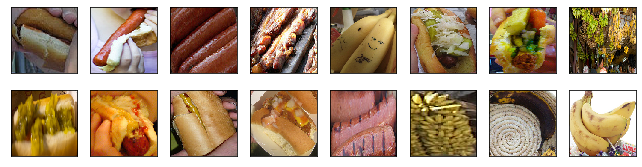

In [12]:
dogs=[next(train_iter)[0][i] for i in range(16)]
axes=show_images(dogs,2,8,scale=1.4)

####9.2.1.2 获取预训练模型
使用keras.applications模块获取预训练模型，其中包含VGG、Resnet和Inception等多种卷积神经网络预训练模型。\
我们使用ImageNet数据集上预训练的vgg16作为源模型，指定include_top=True参数表示不使用最后的全连接分类器层。在第一次使用时需要联网下载模型参数。

In [13]:
pretrained_net=keras.applications.vgg16.VGG16(weights='imagenet',include_top=False)

58892288/58889256 [==============================] - 2s 0us/step


我们输出ResNet50的各层名称看看

In [14]:
for i,layer in enumerate(pretrained_net.layers):
  print(i,layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool


####9.2.1.3. 微调模型
我们在冻结预训练模型的所有权重，在其后添加一个全连接层，再添加一个分类层。

In [0]:
#添加全局平均池化层
x=pretrained_net.output
x=keras.layers.GlobalAveragePooling2D()(x)
#添加一个全连接层
x=keras.layers.Dense(256,activation='relu')(x)
#添加一个分类器，假设我们有200个类
predictions=keras.layers.Dense(2,activation='sigmoid')(x)

#首先，我们只训练顶部的几层（随机初始化的层
#锁住所有其它的卷积层
for layer in pretrained_net.layers:
  layer.trainable=False

#构建我们需要训练的完整模型
model=Model(inputs=pretrained_net.input,outputs=predictions)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [18]:
optimizer=optimizers.SGD(learning_rate=0.005,momentum=0.9)
loss='binary_crossentropy'
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])
model.fit_generator(train_iter,validation_data=test_iter,epochs=10)

Epoch 1/10
32/32 [==============================] - 22s 686ms/step - loss: 0.3001 - acc: 0.8763 - val_loss: 0.3145 - val_acc: 0.8631
Epoch 2/10
32/32 [==============================] - 22s 680ms/step - loss: 0.2898 - acc: 0.8790 - val_loss: 0.3004 - val_acc: 0.8681
Epoch 3/10
32/32 [==============================] - 22s 681ms/step - loss: 0.2806 - acc: 0.8823 - val_loss: 0.2964 - val_acc: 0.8675
Epoch 4/10
32/32 [==============================] - 22s 680ms/step - loss: 0.2786 - acc: 0.8830 - val_loss: 0.2970 - val_acc: 0.8675
Epoch 5/10
32/32 [==============================] - 22s 678ms/step - loss: 0.2783 - acc: 0.8830 - val_loss: 0.2978 - val_acc: 0.8687
Epoch 6/10
32/32 [==============================] - 22s 684ms/step - loss: 0.2754 - acc: 0.8820 - val_loss: 0.2934 - val_acc: 0.8687
Epoch 7/10
32/32 [==============================] - 22s 679ms/step - loss: 0.2813 - acc: 0.8817 - val_loss: 0.2999 - val_acc: 0.8631
Epoch 8/10
32/32 [==============================] - 22s 678ms/step - 

###9.2.2. 小结
* 迁移学习将从源数据集学到的知识迁移到目标数据集上。微调是迁移学习的一种常用技术。
* 目标模型复制了源模型上除了输出层外的所有模型设计及其参数，并基于目标数据集微调这些参数。而目标模型的输出层需要从头训练。